In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
from no_stocks_distribution_model import *
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *

import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Experiment change share of chartists. 

In [3]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [4]:
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

Fix the learning ability at 0.0

In [5]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 450
#params['fundamentalist_horizon_multiplier'] = 0.5

In [6]:
NRUNS = 20

Increment the share of chartists from 0.0 to 100

In [7]:
share_chartists = [x / 100.0 for x in range(10, 110, 10)]

In [8]:
Experiments = len(share_chartists)

In [10]:
Experiments

10

## Run model and update share chartists every time

In [11]:
trdrs = []
orbs = []
for exp in range(Experiments):
    params['strat_share_chartists'] = share_chartists[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        #traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  0
Start of simulation  1
Start of simul

In [12]:
full_share_chartists = []
for exp in range(Experiments):
    for seed in range(NRUNS):
        full_share_chartists.append(share_chartists[exp])

Structure the data

In [13]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [15]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [16]:
redistribution = []
for p in profits:
    redistribution.append(sum(abs(p)))

In [18]:
# calc skew of profits
skew_profits = []
for p in profits:
    skew_profitsofits.append(pd.Series(p).skew())

In [14]:
# # store simulated stylized facts
# mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(
#     orbs, burn_in_period=100)

# obs = len(mc_fundamentals[0])
# r0 = 0.01 + 1.8 / np.sqrt(obs)
# swindow0 = int(math.floor(r0 * obs))
# dim = obs - swindow0 + 1
# IC = 2
# adflag = 6
# yr = 2
# Tb = 12 * yr + swindow0 - 1
# nboot = 99

# perc_bubble_occur = []

# for idx, col in enumerate(mc_returns):
#     pds = pd.Series(mc_prices[idx][:-1] / mc_fundamentals[idx])

#     obs = len(pds)
#     dim = obs - swindow0 + 1

#     bsadfs = PSY(pds, swindow0, IC, adflag)
#     quantilesBsadf = cvPSYwmboot(pds, swindow0, IC, adflag, Tb, nboot)
#     monitorDates = pds.iloc[swindow0 - 1:obs].index
#     quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
#     ind95 = (bsadfs.T[0] > quantile95[1,])
#     periods = monitorDates[ind95]

#     if True in ind95:
#         bubbly_dates = find_sequences_ints(periods, monitorDates)
#         perc_bubble_occur.append(len(periods) / float(len(monitorDates)))
#     else: 
#         perc_bubble_occur.append(0.0)

In [17]:
# data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
#                      'share_chartists': np.log(full_share_chartists[:]), 'perc_b_occur': perc_bubble_occur,
#                      'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})

data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
                     'share_chartists': np.log(full_share_chartists[:]),
                     'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})
data['const'] = 1

In [15]:
# # Get the t-critical value**
# def confidence_interval(sample, emp_value):
#     """Calculate confidence_interval in sample"""
#     z_critical = stats.norm.ppf(q = 0.99)
#     stdev = pd.Series(sample).std()
#     margin_of_error = z_critical * stdev
#     confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
#     return confidence_interval

In [16]:
# def reject_outliers(data, m = 2.):
#     d = np.abs(data - np.median(data))
#     mdev = np.median(d)
#     s = d/mdev if mdev else 0.
#     return data[s<m]

In [20]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

twtw_averages = []
twtw_conf_interval_uppers = []
twtw_conf_intervals_lowers = []

price_div_stdev_av = []
price_div_stdev_uppers = []
price_div_stdev_lowers = []

redistr_av = []
redistr_uppers = []
redistr_lowers = []

skew_profits_av = []
skew_profits_uppers = []
skew_profits_lowers = []

for x in range(Experiments):
    y = x*10
    g = ginis[y:y+10]
    pstdev = price_to_div_stdev[y: y+10]
    redr = redistribution[y: y+10]
    skw = skew_profits[y: y+10]
    
    # redistribution
    redistr_av.append(np.mean(redr))
    sample_stdev = np.std(redr)
    sigma = sample_stdev/math.sqrt(len(redr))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(redr), scale = sigma) 
    redistr_uppers.append(upper)
    redistr_lowers.append(lower)
    
    # skew profits
    skew_profits_av.append(np.mean(skw))
    sample_stdev = np.std(skw)
    sigma = sample_stdev/math.sqrt(len(skw))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(skw), scale = sigma) 
    skew_profits_uppers.append(upper)
    skew_profits_lowers.append(lower)
    
    price_div_stdev_av.append(np.mean(pstdev))
    #lower, upper = confidence_interval(g, np.median(pstdev))
    sample_stdev = np.std(pstdev)
    sigma = sample_stdev/math.sqrt(len(pstdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pstdev), scale = sigma) 
    price_div_stdev_uppers.append(upper)
    price_div_stdev_lowers.append(max(lower, 0))
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    #lower, upper = confidence_interval(g, np.median(g))
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = np.array(palmas[y:y+10])
    palma_averages.append(np.mean(p))
    #lower, upper = confidence_interval(p, np.median(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    tw = np.array(twtws[y:y+10])
    twtw_averages.append(np.mean(tw))
    #lower, upper = confidence_interval(tw, np.median(tw))
    sample_stdev = np.std(tw)
    sigma = sample_stdev/math.sqrt(len(tw))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(tw), scale = sigma) 
    twtw_conf_interval_uppers.append(upper)
    twtw_conf_intervals_lowers.append(max(lower, 0))

In [21]:
len(price_to_div_stdev)

200

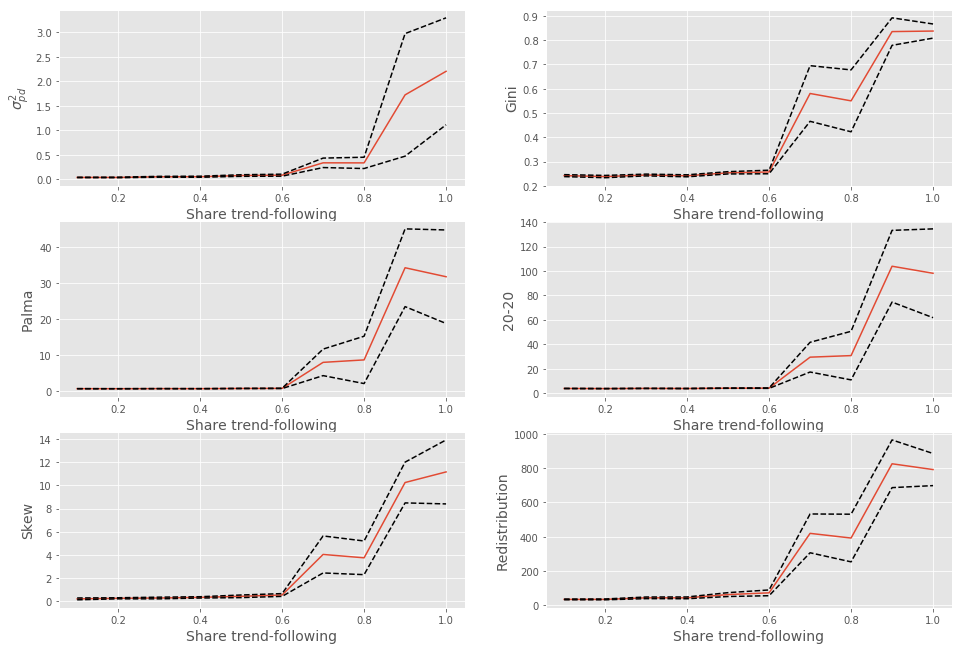

In [24]:
fig, ((ax1, ax2), (ax3, ax4), (ax5 ,ax6)) = plt.subplots(3, 2, figsize=[16,11])

ax1.plot(share_chartists, price_div_stdev_av)
ax1.plot(share_chartists, price_div_stdev_uppers, 'k--')
ax1.plot(share_chartists, price_div_stdev_lowers, 'k--')

ax2.plot(share_chartists, gini_averages)
ax2.plot(share_chartists, gini_conf_interval_uppers, 'k--')
ax2.plot(share_chartists, gini_conf_intervals_lowers, 'k--')

ax3.plot(share_chartists, palma_averages)
ax3.plot(share_chartists, palma_conf_interval_uppers, 'k--')
ax3.plot(share_chartists, palma_conf_intervals_lowers, 'k--')

ax4.plot(share_chartists, twtw_averages)
ax4.plot(share_chartists, twtw_conf_interval_uppers, 'k--')
ax4.plot(share_chartists, twtw_conf_intervals_lowers, 'k--')

ax5.plot(share_chartists, skew_profits_av)
ax5.plot(share_chartists, skew_profits_uppers, 'k--')
ax5.plot(share_chartists, skew_profits_lowers, 'k--')

ax6.plot(share_chartists, redistr_av)
ax6.plot(share_chartists, redistr_uppers, 'k--')
ax6.plot(share_chartists, redistr_lowers, 'k--')

ax1.set_ylabel('$\sigma^2_{pd}$', fontsize=14)
ax2.set_ylabel('Gini', fontsize=14)
ax3.set_ylabel('Palma', fontsize=14)
ax4.set_ylabel('20-20', fontsize=14)
ax5.set_ylabel('Skew', fontsize=14)
ax6.set_ylabel('Redistribution', fontsize=14)


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('Share trend-following', fontsize=14)

fig.savefig('share_chartists_inequality2.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
pd.Series(perc_bubble_occur).plot()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(data['lin_share_chartists'], asset_price_inflation)
ax2.scatter(data['lin_share_chartists'], perc_bubble_occur)


ax1.set_title('Asset_price_inflation')
ax2.set_title('Percentage bubble occur')

for ax in [ax1, ax2]:
    ax.set_xlabel('Share chartists')
    
fig.savefig('share_chartists_prices_bubbles.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Regression


In [22]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
#pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
#perc_bubble_res = sm.OLS(endog=data['perc_b_occur'], exog=data[['const', 'share_chartists']], missing='drop').fit()

In [24]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                         Gini               Palma              20-20       
---------------------------------------------------------------------------
const            -1.4957***          0.0415              1.9169***         
                 (0.0152)            (0.0776)            (0.1064)          
share_chartists  -0.0233*            0.1901***           0.3146***         
                 (0.0128)            (0.0541)            (0.0733)          
R-squared        0.05393482046697562 0.24539021387486104 0.3321805549618282
No. observations 60                  40                  39                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
# info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
#            'No. observations' : lambda x: "{}".format(int(x.nobs))}

# results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, perc_bubble_res],
#                             float_format='%0.4f',
#                             stars = True,
#                             model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Bubble occur'],
#                             info_dict=info_dict,
#                             regressor_order=['const', 'share_chartists'])

# results_table.add_title('Table - OLS Regressions')

# print(results_table)

# Experiment 2

Hypothesis, income inequality is a consequence of price fluctuations: 

Everyone is a fundamentalist. High noise 

In [19]:
params['strat_share_chartists'] = 0.001
params['average_learning_ability'] = 0.0
params['fundamentalist_horizon_multiplier'] = 0.2

In [23]:
stdev_fundamental = [x / 10.0 for x in range(5, 105, 20)]

In [26]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['std_fundamental'] = stdev_fundamental[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


In [27]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [28]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'stdev_fund': np.log(stdev_fundamental[1:]), 'lin_stdev_fund': stdev_fundamental[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

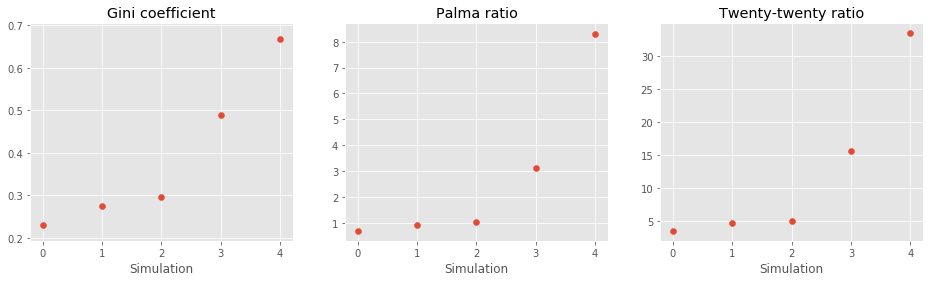

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')


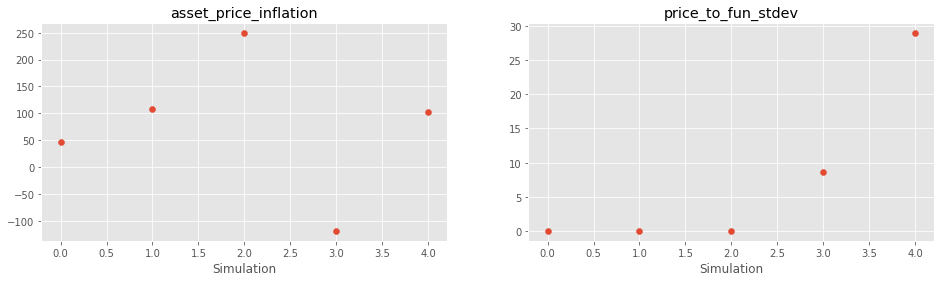

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_fun_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

Text(0, 0.5, 'PF ratio')

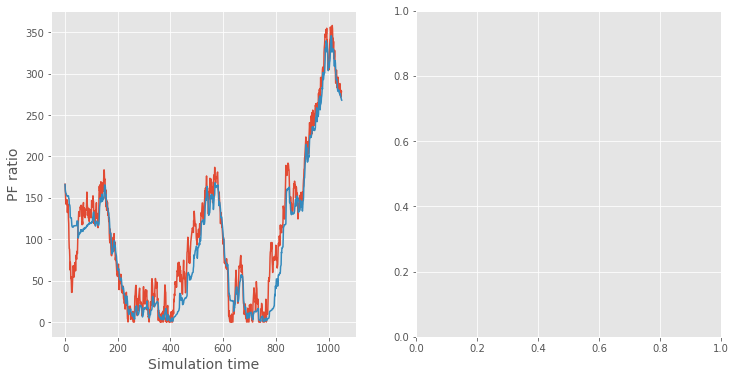

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(range(len(orbs[idx].fundamental[1:])), orbs[idx].fundamental[1:], label='fundamental')
ax1.plot(range(len(orbs[idx].tick_close_price[1:])), orbs[idx].tick_close_price[1:], label='fundamental')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PF ratio', fontsize='14')

